
# Загрузка данных

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import CatBoostEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import BorderlineSMOTE
import joblib
import os
from sklearn.impute import SimpleImputer

# Путь к файлу (относительно текущего .ipynb)
file_path = os.path.join('data', 'processed_with_all_features.csv')

# Загружаем данные
data = pd.read_csv(file_path)


print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date                             1120 non-null   object 
 1   HomeTeam                         1120 non-null   object 
 2   AwayTeam                         1120 non-null   object 
 3   FTR                              1120 non-null   object 
 4   HTHG                             1120 non-null   int64  
 5   HTAG                             1120 non-null   int64  
 6   HS                               1120 non-null   int64  
 7   AS                               1120 non-null   int64  
 8   HST                              1120 non-null   int64  
 9   AST                              1120 non-null   int64  
 10  HF                               1120 non-null   int64  
 11  AF                               1120 non-null   int64  
 12  HC                  

,Date,HomeTeam,AwayTeam,FTR,HTHG,HTAG,HS,AS,HST,AST,...,HeadToHead_HomeWinRate,HeadToHead_AwayWinRate,HeadToHead_HomeGoals,HeadToHead_AwayGoals,HomeTeam_GlobalAvgGoalsScored,HomeTeam_GlobalAvgGoalsConceded,AwayTeam_GlobalAvgGoalsScored,AwayTeam_GlobalAvgGoalsConceded,HomeTeam_Elo,AwayTeam_Elo
0,2022-08-05,Crystal Palace,Arsenal,A,0,1,10,10,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,1500.0
1,2022-08-06,Fulham,Liverpool,D,1,0,9,11,3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,1500.0
2,2022-08-06,Bournemouth,Aston Villa,H,1,0,7,15,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,1500.0
3,2022-08-06,Leeds,Wolves,H,1,1,12,15,4,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,1500.0
4,2022-08-06,Newcastle,Nott'm Forest,H,0,0,23,5,10,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,1500.0


# Выделим только числовые признаки для анализа корреляции

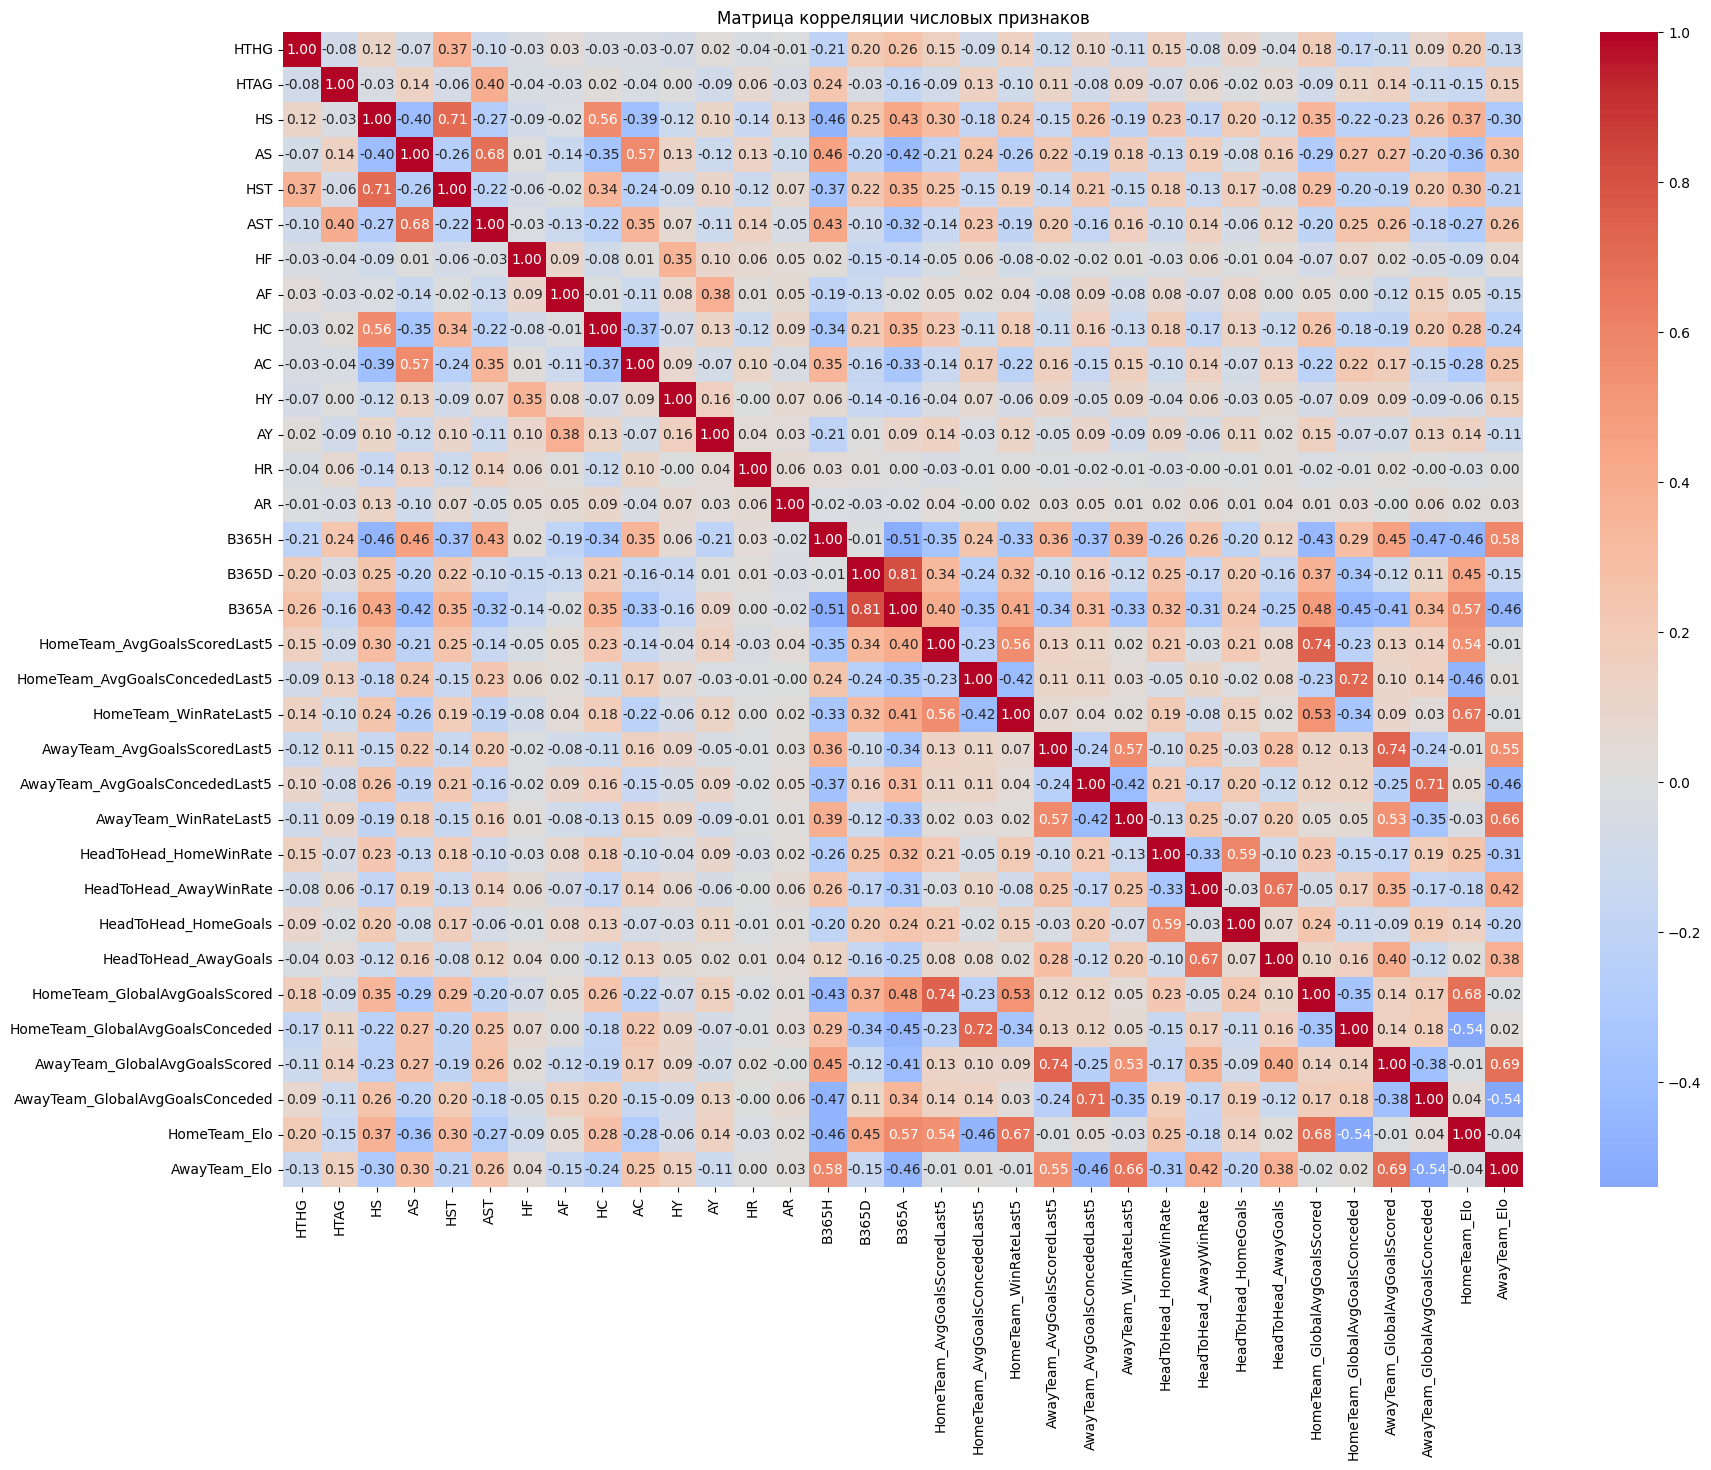

In [7]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numerical_features].corr()

# Визуализация матрицы корреляции
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Матрица корреляции числовых признаков')
plt.show()


# Вывод сильно коррелирующих признаков (например, с коэффициентом > 0.8 или < -0.8)

In [8]:
high_correlation = correlation_matrix.abs().stack().reset_index()
high_correlation.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation = high_correlation[high_correlation['Feature 1'] != high_correlation['Feature 2']]
high_correlation = high_correlation.sort_values(by='Correlation', ascending=False)
high_correlation = high_correlation[high_correlation['Correlation'] > 0.73]

print("Сильно коррелирующие признаки:")
print(high_correlation)

Сильно коррелирующие признаки:
                         Feature 1                      Feature 2  Correlation
543                          B365A                          B365D     0.813568
511                          B365D                          B365A     0.813568
588   HomeTeam_AvgGoalsScoredLast5  HomeTeam_GlobalAvgGoalsScored     0.744577
908  HomeTeam_GlobalAvgGoalsScored   HomeTeam_AvgGoalsScoredLast5     0.744577
977  AwayTeam_GlobalAvgGoalsScored   AwayTeam_AvgGoalsScoredLast5     0.740056
689   AwayTeam_AvgGoalsScoredLast5  AwayTeam_GlobalAvgGoalsScored     0.740056


#  Анализ уникальных значений
## Проверим количество уникальных значений для каждого категориального признака.

In [9]:
# Список категориальных признаков (пример)
categorical_features = data.select_dtypes(include=['object', 'category']).columns
print("Категориальные признаки:", list(categorical_features))

Категориальные признаки: ['Date', 'HomeTeam', 'AwayTeam', 'FTR']


In [10]:
for feature in categorical_features:
    unique_values = data[feature].nunique()
    print(f"{feature}: {unique_values} уникальных значений")

Date: 341 уникальных значений
HomeTeam: 24 уникальных значений
AwayTeam: 24 уникальных значений
FTR: 3 уникальных значений


Выбор методов кодирования
На основе анализа выбираем методы:

Признак	        Тип	            Метод кодирования
HomeTeam	    Номинальный	    One-Hot Encoding
AwayTeam	    Номинальный	    One-Hot Encoding
FTR	            Порядковый	Ordinal Encoding (H=2, D=1, A=0)
Date	        Высококардинальный	Преобразовать в datetime + признаки


In [11]:
ftr_mapping = {'A': 0, 'D': 1, 'H': 2}
data['FTR'] = data['FTR'].map(ftr_mapping)

In [12]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data.drop('Date', axis=1, inplace=True)

In [13]:
encoder = CatBoostEncoder()
encoded_teams = encoder.fit_transform(data[['HomeTeam', 'AwayTeam']], data['FTR'])
data[['HomeTeam_encoded', 'AwayTeam_encoded']] = encoded_teams
data.drop(['HomeTeam', 'AwayTeam'], axis=1, inplace=True)

In [14]:
print(data.head())
print("\nНовые признаки после кодирования:", list(data.columns))

   FTR  HTHG  HTAG  HS  AS  HST  AST  HF  AF  HC  ...  \
0    0     0     1  10  10    2    2  16  11   3  ...   
1    1     1     0   9  11    3    4   7   9   4  ...   
2    2     1     0   7  15    3    2  18  16   5  ...   
3    2     1     1  12  15    4    6  13   9   6  ...   
4    2     0     0  23   5   10    0   9  14  11  ...   

   HomeTeam_GlobalAvgGoalsConceded  AwayTeam_GlobalAvgGoalsScored  \
0                              0.0                            0.0   
1                              0.0                            0.0   
2                              0.0                            0.0   
3                              0.0                            0.0   
4                              0.0                            0.0   

   AwayTeam_GlobalAvgGoalsConceded  HomeTeam_Elo  AwayTeam_Elo  Year  Month  \
0                              0.0        1500.0        1500.0  2022      8   
1                              0.0        1500.0        1500.0  2022      8   
2    

In [15]:
print(data[['HomeTeam_encoded', 'AwayTeam_encoded']].describe())

       HomeTeam_encoded  AwayTeam_encoded
count       1120.000000       1120.000000
mean           1.167623          1.166439
std            0.349590          0.288721
min            0.141518          0.375649
25%            0.976672          1.007665
50%            1.135517          1.191629
75%            1.425159          1.375292
max            1.891518          1.855357


In [16]:
print(data['FTR'].value_counts(normalize=True))

FTR
2    0.450000
0    0.317857
1    0.232143
Name: proportion, dtype: float64


# Разбиение на выборки

In [17]:
X = data.drop('FTR', axis=1)
y = data['FTR']

# ---  Разделение на трейн/тест ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Сохраняем распределение классов
)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (896, 38)
Размер тестовой выборки: (224, 38)


Стандартизируем обучающую и валидационную выборки, т.к. есть в некоторых признаках большой разброс значений. 


In [18]:
# Инициализируем scaler
scaler = StandardScaler()

# Обучаем scaler ТОЛЬКО на обучающих данных
X_train_scaled = scaler.fit_transform(X_train)

# Применяем ТОЛЬКО transform к тестовой выборке
X_test_scaled = scaler.transform(X_test)

определение целевой переменной для того чтобы понять нужна ли балансировка

In [19]:

# Проверяем распределение FTR
print(data['FTR'].value_counts(normalize=True))

FTR
2    0.450000
0    0.317857
1    0.232143
Name: proportion, dtype: float64


Балансировка нужна, так как есть явное смещение FTR2 (победа дома) 
Теперь будем использовать разные методы для сбалансирования классов

In [20]:
# Инициализация моделей
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Для моделей с class_weight
weighted_models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}
# Бинаризация меток
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
# Функция для оценки моделей
def evaluate_model(model, X_train, y_train, X_test, y_test, method_name=""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # ROC AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Вывод результатов
    print(f"\nMethod: {method_name} | Model: {model.__class__.__name__}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average AUC: {np.mean(list(roc_auc.values())):.4f}")
    print(classification_report(y_test, y_pred))
    
    return fpr[1], tpr[1], roc_auc[1]  # Возвращаем ROC для класса D

SMOTE (Synthetic Minority Over-sampling Technique)

In [21]:

# Применяем SMOTE только к обучающим данным
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("До SMOTE:", Counter(y_train))
print("После SMOTE:", Counter(y_train_smote))

c:\Users\ДНС\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\ДНС\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


До SMOTE: Counter({2: 403, 0: 285, 1: 208})
После SMOTE: Counter({2: 403, 1: 403, 0: 403})


c:\Users\ДНС\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\ДНС\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Random Forest with SMOTE:
F1 Score: 0.6021
Average AUC: 0.7591

Gradient Boosting with SMOTE:
F1 Score: 0.6204
Average AUC: 0.7711

Logistic Regression with SMOTE:
F1 Score: 0.5712
Average AUC: 0.7680


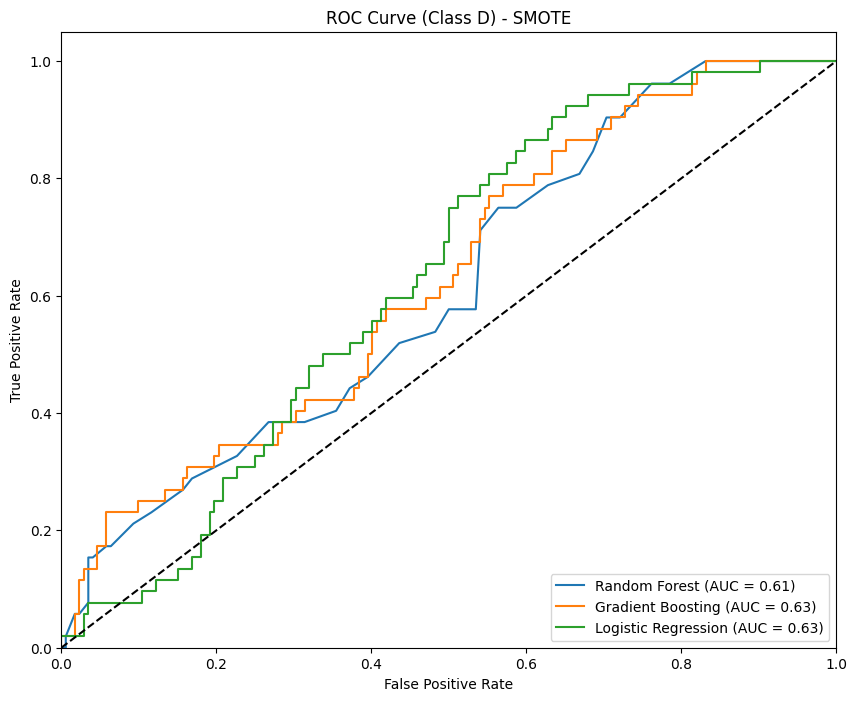

In [22]:

# Бинаризуем метки
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)
    
    # ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    mean_auc = np.mean(list(roc_auc.values()))
    plt.plot(fpr[1], tpr[1], label=f'{name} (AUC = {roc_auc[1]:.2f})')
    
    # F1 и вывод
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\n{name} with SMOTE:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average AUC: {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Class D) - SMOTE')
plt.legend(loc="lower right")
plt.show()

2. ADASYN 

c:\Users\ДНС\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\ДНС\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The ADASYN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Random Forest with ADASYN:
F1 Score: 0.5864
Average AUC: 0.7560

Gradient Boosting with ADASYN:
F1 Score: 0.6215
Average AUC: 0.7758

Logistic Regression with ADASYN:
F1 Score: 0.5677
Average AUC: 0.7730


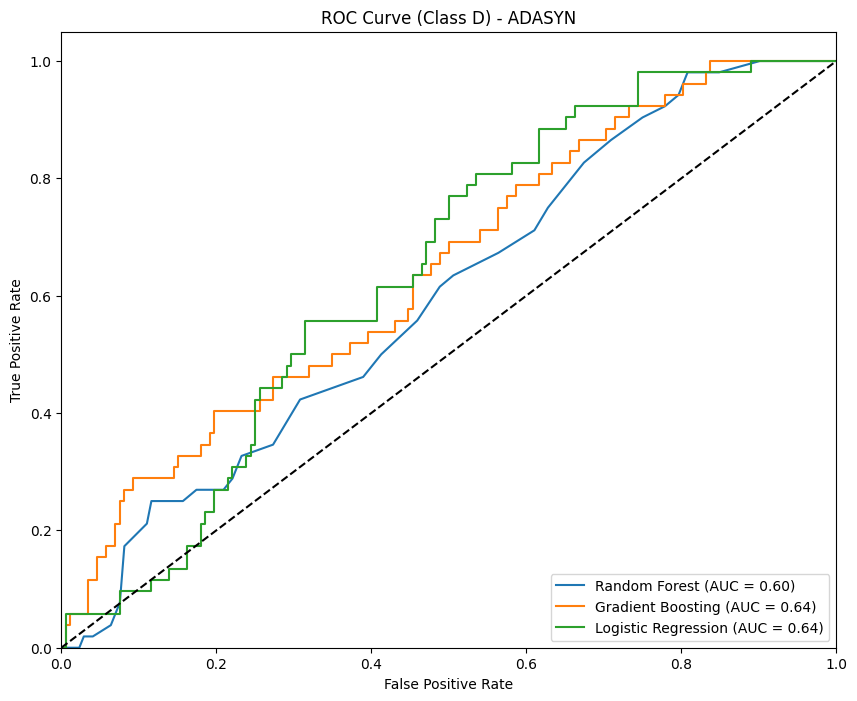

In [23]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_train_adasyn, y_train_adasyn)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    mean_auc = np.mean(list(roc_auc.values()))
    plt.plot(fpr[1], tpr[1], label=f'{name} (AUC = {roc_auc[1]:.2f})')
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\n{name} with ADASYN:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average AUC: {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Class D) - ADASYN')
plt.legend(loc="lower right")
plt.show()

Random Undersampling с ROC-анализом

c:\Users\ДНС\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ДНС\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\ДНС\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



Random Forest with Random Undersampling:
F1 Score: 0.5845
Average AUC: 0.7279

Gradient Boosting with Random Undersampling:
F1 Score: 0.6147
Average AUC: 0.7606

Logistic Regression with Random Undersampling:
F1 Score: 0.5979
Average AUC: 0.7605


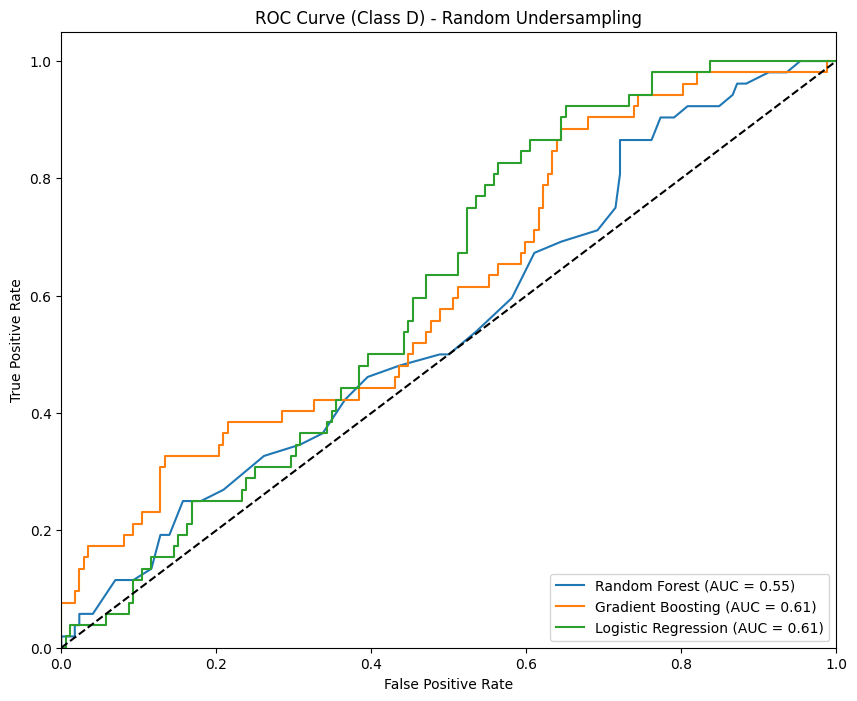

In [24]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

plt.figure(figsize=(10, 8))
for name, model in models.items():
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    mean_auc = np.mean(list(roc_auc.values()))
    plt.plot(fpr[1], tpr[1], label=f'{name} (AUC = {roc_auc[1]:.2f})')
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\n{name} with Random Undersampling:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average AUC: {mean_auc:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Class D) - Random Undersampling')
plt.legend(loc="lower right")
plt.show()

# Общий вывод:

Видно то, что ROC-кривая показала, что модель Logistic Regression с MOTE лучше чем всё остальное :)

Эту модель и метод мы будем использовать для нашего приложения


In [25]:
# Сохраняем список признаков
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_imputed = imputer.fit_transform(X_train)

joblib.dump(imputer, 'models/imputer.pkl')
# Сохраняем модель
joblib.dump(model, 'logistic_model.pkl')

# Сохраняем scaler
joblib.dump(scaler, 'scaler.pkl')

# Сохраняем encoder (CatBoostEncoder)
joblib.dump(encoder, 'encoder.pkl')


['encoder.pkl']